In [1]:

#import matplotlib.pyplot as plt
import os
import torch
from src.rgcn_explainer_utils import *
import pandas as pd
import numpy as np
import src.kgbench as kg

In [2]:
# Get the current directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Check if the current directory is already the parent directory
if current_dir != '/Users/macoftraopia/Documents/GitHub/RGCN-Explainer':
    # Set the parent directory as the current directory
    os.chdir(parent_dir)
!pwd

/Users/macoftraopia/Documents/GitHub/RGCN-Explainer


In [35]:
path = 'chk/aifb_chk/exp/init_normal_hops_2_lr_0.1_adaptive_False_size_5e-05_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/masked_adj'
#path = 'chk/aifb_chk/exp/init_normal_hops_2_lr_0.1_adaptive_False_size_5e-05_sizestd_adaptive_ent_10_type_-1_killtype_False_break_no/masked_adj'
node_idx = 5678
n_hop = 2
threshold = 0.5
name = 'aifb'
data = kg.load(name, torch=True)
d_classes(data)


v = torch.load(f'{path}/masked_ver{node_idx}')
h = torch.load(f'{path}/masked_hor{node_idx}')

loaded data aifb (0.2278s).


In [40]:
h_t, v_t,t = threshold_mask(h,v,data,15)
t

tensor(0.4971)

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


Counter({'author': 6, 'publication': 4, 'member': 2, 'isWorkedOnBy': 2})


Counter({'author': 6, 'member': 2, 'publication': 4, 'isWorkedOnBy': 2})

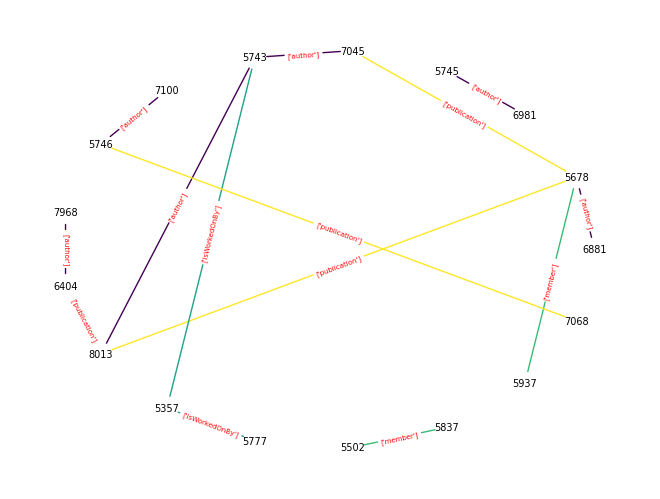

In [41]:
visualize(node_idx, n_hop, data, v_t,threshold,name, result_weights=False, low_threshold=False,experiment_name=None, selected_visualization=True,connected_subgraph=False)

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


Counter({'author': 9, 'publication': 7, 'isWorkedOnBy': 5, 'member': 2, 'worksAtProject': 1})


Counter({'author': 9,
         'member': 2,
         'publication': 7,
         'isWorkedOnBy': 5,
         'worksAtProject': 1})

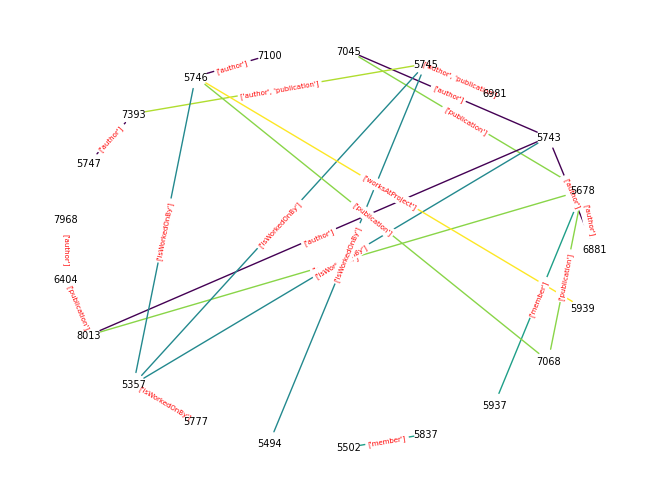

In [37]:
def visualize(node_idx, n_hop, data, masked_ver,threshold,name, result_weights=True, low_threshold=False,experiment_name=None, selected_visualization=True, connected_subgraph = True):
    """ 
    Visualize important nodes for node idx prediction
    """
    get_relations(data)
    dict_index = dict_index_classes(data,masked_ver)
    
    #select only nodes with a certain threshold
    if selected_visualization:
        sel_masked_ver = sub_sparse_tensor(masked_ver, threshold,data, low_threshold)
        sel_masked_hor = sub_sparse_tensor(masked_ver, threshold,data, low_threshold)
    else:
        sel_masked_ver = masked_ver
        sel_masked_hor = masked_ver
    if len(sel_masked_ver)==0:
        sel_masked_ver=sub_sparse_tensor(masked_ver, 0,data, low_threshold)
    #print('sel masked ver',sel_masked_ver)
    indices_nodes = sel_masked_ver.coalesce().indices().detach().numpy()
    new_index = np.transpose(np.stack((indices_nodes[0], indices_nodes[1]))) #original edge indexes

    
    
    G = nx.Graph()
    if result_weights:
        values = sel_masked_ver.coalesce().values().tolist()
        for s,p,o in zip(indices_nodes[0],values , indices_nodes[1]):
            G.add_edge(int(s), int(o), weight=np.round(p, 2))

    else:

        triples_matched = match_to_triples(sel_masked_ver,sel_masked_hor, data)
        l = []
        for i in triples_matched[:,1]:
            l.append(data.i2rel[int(i)][0])
        triples_matched = find_repeating_sublists(triples_matched.tolist())
        for s,p,o in triples_matched:
            G.add_edge(int(s), int(o), weight=p)
    if connected_subgraph:
        #conncected subgraph
        connected_components = nx.connected_components(G)
        component = next(connected_components)
        G = G.subgraph(component)

    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = [[item] if not isinstance(item, list) else item for item in weights]


    pos = nx.circular_layout(G)
    #pos = nx.spring_layout(G)

    ordered_dict = {}
    for item in list(G.nodes):
        if item in ordered_dict:
            ordered_dict[item].append(dict_index[item])
        # else:
        #     ordered_dict[item] =  dict_index[item]

    dict_index = ordered_dict

    labeldict = {}
    for node in G.nodes:
        labeldict[int(node)] = int(node)  

    dict = {}
    for k,v in dict_index.items():
        for k1,v1 in data.entities_classes.items():
            if v==k1: 

                dict[k] = v1
                print(v1)
            else:
                if k not in dict:
                    dict[k] = 0
                

    color_list = list(dict.values())
    #color_list = list(encode_dict(dict_index).values())
    col_weights = [weights[i][0] for i in range(len(weights))]
    if result_weights:
        
        nx.draw(G, pos,labels = labeldict,  edgelist=edges, edge_color=col_weights, node_color =  color_list, cmap="Set2",edge_cmap=plt.cm.Reds,font_size=8)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=nx.get_edge_attributes(G,'weight'),font_size=8,font_color='red')
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=1))
        sm.set_array(weights)
        cbar = plt.colorbar(sm)
        cbar.ax.set_title('Weight')
        plt.title("Node {}'s {}-hop neighborhood important nodes".format(node_idx, n_hop))
    else:
        re = nx.get_edge_attributes(G, 'weight')
        rel =  {k: list(set(v)) for k, v in re.items()}

        for k, v in rel.items():
            if isinstance(v, list):
                updated_values = [data.i2rel[item][0] for item in v]
                rel[k] = updated_values
            else:
                rel[k] = data.i2rel[v][0]

        col_weights = [sum(weights[i]) if len(weights[i]) > 1 else weights[i][0] for i in range(len(weights))]
        nx.draw(G, pos,labels = labeldict, edge_color=col_weights,edgelist=edges,node_color =  color_list, cmap="Set2",font_size=7, arrows = True)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=rel,font_size=5,font_color='red')
        
        res = Counter(unnest_list(rel.values()))
        print(res)
    if result_weights:
        if not os.path.exists(f'chk/{name}_chk/{experiment_name}⁄graphs'):
            os.makedirs(f'chk/{name}_chk/{experiment_name}⁄graphs')  
        plt.savefig(f'chk/{name}_chk/{experiment_name}⁄graphs/Explanation_{node_idx}_weights.png')

        #plt.show()

    else:
        if not os.path.exists(f'chk/{name}_chk/{experiment_name}⁄graphs'):
            os.makedirs(f'chk/{name}_chk/{experiment_name}⁄graphs')  
        plt.savefig(f'chk/{name}_chk/{experiment_name}⁄graphs/Explanation_{node_idx}_relations.png')    
        #plt.show()
        return res
    
visualize(node_idx, n_hop, data, v_t,threshold,name, result_weights=False, low_threshold=False,experiment_name=None, selected_visualization=True,connected_subgraph=False)



Counter({'author': 2, 'isWorkedOnBy': 2, 'member': 1, 'publication': 1})


/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


Counter({'author': 2, 'isWorkedOnBy': 2, 'member': 1, 'publication': 1})

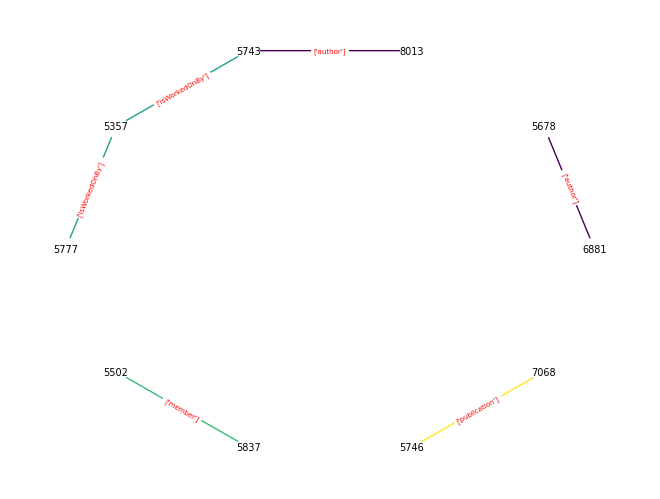

In [42]:
visualize(node_idx, n_hop, data, v,threshold,name, result_weights=False, low_threshold=False,experiment_name=None, selected_visualization=True, connected_subgraph=False)